# Importação de bibliotecas

In [1]:
import numpy as np # criação e manipulação de vetores
import matplotlib.pyplot as plt # graficos
import pandas as pd # read csv file
from scipy.optimize import minimize
from sklearn.metrics import r2_score

# Formatação para gráficos

In [2]:
ft = 16
plt.rcParams.update({'font.size':ft})
ft2 = 20

# Leitura de base de dados

In [3]:
df = pd.read_excel('data.xlsx')

In [4]:
df.head()

,T,k
0,300,6706
1,298,6698
2,330,6657
3,349,6880
4,364,6791


A estimação de parâmetros envolve o ajuste de parâmetros em um modelo e refere-se a um problema de otimização. 

Em muitos casos, uma equação diferencial linear de primeira ordem pode aproximar a evolução de muitos sistemas. Os parâmetros desconhecidos para o sistema que iremos estudar como estudo de caso incluem o fator pré-exponencial ($A$) e a energia de ativação ($E_a$).

Nosso modelo:

$$
k(T) = A\cdot e^{-\frac{E_a}{RT}}
$$

In [5]:
R = 8.31451

O conjunto de dados em df corresponde a dados medidos experimentalmente.

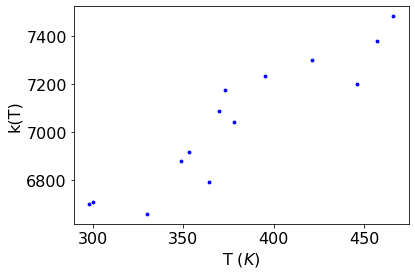

In [6]:
color1 = 'blue'
plt.xlabel('T ($K$)')
plt.ylabel('k(T)')
plt.scatter(df['T'],df['k'],c = color1,marker = 'o',s = 8)

plt.savefig('OriginalData.png',format='png',dpi = 600,bbox_inches = 'tight')
plt.show()

# Apresentação do problema a ser resolvido

Ajuste os dados a um sistema linear de primeira ordem estimando $E_a$ e $A$. Determine os intervalos de confiança de $95 \%$ e $99 \%$ para os parâmetros.

# Aplicação do método de otimização

Ver a seguinte referência:
- https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

In [7]:
modelo = lambda k1,k2,Temp: k1*np.exp(-k2/(R*Temp))

## Definição da função objetivo

Dessa vez, vamos adaptar a função objetivo salvando todos os parâmetros testados pelo método de otimização e o resultado SSE obtido para cada par de parâmetros selecionado. 

In [8]:
def Fobj(par):
    global RC
    dftemp = df.copy()
    dftemp['km'] = modelo(par[0],par[1],dftemp['T']) # km = k modelo
    dftemp['error'] = (dftemp['k'] - dftemp['km'])**2
    SSE = dftemp['error'].sum() # residual sum of squares
    RC = RC.append({'A':par[0],'Ea':par[1],'Fobj':SSE}, ignore_index=True)
    return SSE

Uma vez que criamos nossa função objetivo, sem considerar os erros experimentais, estamos assumindo a hipótese de que os experimentos foram muito bem feitos e os erros experimentais podem ser desprezados. Como a nossa função objetivo é a métrica SSE, a chamamos de **função objetivo de mínimos quadrados**. 

Para mais informações sobre formulação de função objetivo, consulte as seguintes referências: 
- [Análise de Dados Experimentais 1: Fundamentos de Estatística e Estimação de Parâmetros, autores: Marcio Schwaab e José Carlos Pinto, editora: e-papers, 2007.](http://www.e-papers.com.br/produtos.asp?codigo_produto=2792)

- [wikipedia](https://pt.wikipedia.org/wiki/Método_dos_m%C3%ADnimos_quadrados)

- Escolhemos o método de otimização BFGS para estudo

In [9]:
x0 = [200,100] # na ordem: A e Ea
global RC
RC = pd.DataFrame()

In [10]:
RC 

""


In [11]:
res = minimize(Fobj, x0, method='BFGS',options={'disp': True})

         Current function value: 143607.435782
         Iterations: 22
         Function evaluations: 209
         Gradient evaluations: 66


- Parâmetros estimados:

In [12]:
res.x

array([9028.49808157,  770.5885364 ])

- adicionando uma nova coluna em df correspondente aos valores de *k* preditos pelo modelo com os parâmetros já estimados

In [13]:
df['km'] = modelo(res.x[0],res.x[1],df['T'])

In [14]:
df.head()

,T,k,km
0,300,6706,6628.992257
1,298,6698,6615.262093
2,330,6657,6817.805423
3,349,6880,6922.848897
4,364,6791,6999.024109


# Métricas de regressão

## SSE: 

- Error sum of squares
- Soma dos erros ao quadrado

$$
SSE = \sum_{i=1}^{N} (y_{original} - y_{predito})^2
$$

In [15]:
SSE = res.fun
SSE

143607.4357820648

## MSE:

- Mean squared error
- Erro quadrático médio

$$
MSE = \frac{1}{N}\sum_{i=1}^{N} (y_{original} - y_{predito})^2
$$

In [16]:
N = df['T'].index[-1]+1
N 

14

In [17]:
MSE = SSE/N
MSE

10257.6739844332

## RMSE:

- Root-mean-square deviation
- Raiz do erro quadrático médio

$$
RMSE = \sqrt{MSE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N} (y_{original} - y_{predito})^2}
$$

In [18]:
RMSE = MSE**0.5
RMSE

101.28017567339228

## $R^2$

- Coefficient of determination
- Coeficiente de determinação

$$
R^2 = 1 - \frac{SSE}{\sum_{i=1}^{N}(y_{original} - y_{média})^2}
$$

In [19]:
R2 = r2_score(df['k'],df['km'])
R2

0.8476432377266169

In [20]:
result = pd.DataFrame({'SSE':[res.fun],
             'MSE':[MSE],
              'RMSE':[RMSE],
              'R2':[R2],
             'A':[res.x[0]],
             'Ea':[res.x[1]],
             '$N_{it}$':[res.nit],
             '$N_{fun_{eval}}$':[res.nfev]},
             index = ['BFGS']).T

In [21]:
result

,BFGS
SSE,143607.435782
MSE,10257.673984
RMSE,101.280176
R2,0.847643
A,9028.498082
Ea,770.588536
$N_{it}$,22.000000
$N_{fun_{eval}}$,209.000000


# Visualização gráfica dos resultados

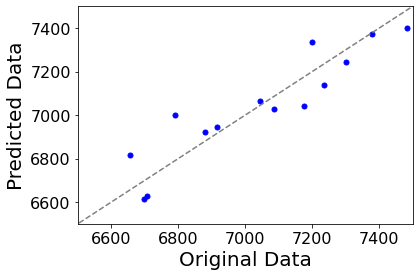

In [22]:
color1 = 'blue'
plt.xlabel('Original Data',fontsize = ft2)
plt.ylabel('Predicted Data',fontsize = ft2)
plt.scatter(df['k'],df['km'],c = color1,marker = 'o',s = 25)
color2 = 'grey'
plt.plot([6000,8000],[6000,8000],c=color2,linestyle='--')
plt.xlim([6500,7500])
plt.ylim([6500,7500])
plt.savefig('finalplot.png',format='png',dpi = 600,bbox_inches = 'tight')
plt.show()

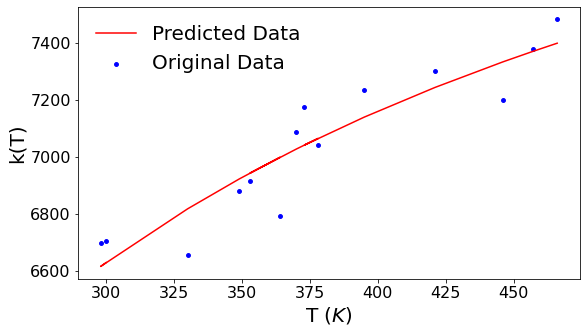

In [23]:
plt.figure(figsize=(9,5))
color1 = 'blue'
plt.xlabel('T ($K$)',fontsize = ft2)
plt.ylabel('k(T)',fontsize = ft2)
plt.scatter(df['T'],df['k'],c = color1,marker = 'o',s = 15,label = 'Original Data')
color2 = 'red'
plt.plot(df['T'],df['km'],c=color2, label = 'Predicted Data')
plt.legend(frameon = False,fontsize = ft2)
plt.savefig('finalplot2.png',format='png',dpi = 600,bbox_inches = 'tight')
plt.show()

# F-teste & Região de Confiança

O teste F é mais frequentemente usado ao comparar modelos estatísticos que foram ajustados a um conjunto de dados, a fim de identificar o modelo que melhor se ajusta à população da qual os dados foram amostrados. Os "testes F" exatos surgem principalmente quando os modelos foram ajustados aos dados usando a **função objetivo de  mínimos quadrados** e esse é o nosso caso. 

O teste F é um teste estatístico com o propósito de comparar como 2 conjuntos de dados estão alinhados. Temos 2 conjuntos no nosso caso:
- o primeiro conjunto é o $S(\theta)$
- o segundo conjunto é o $S(\theta^*)$ que é o conjunto ótimo encontrado pelo método de otimização. $\theta^*$ são os parâmetros estimados (*ponto ótimo*). 

Os intervalos de confiança não lineares também podem ser visualizados em função de 2 parâmetros. Nesse caso, ambos os parâmetros são variados simultaneamente para encontrar a região de confiança. O intervalo de confiança é determinado com um teste F que especifica um limite superior para o desvio da solução ideal:

$$
\frac{S(\theta)-S(\theta^*)}{S(\theta^*)} \leq \frac{p}{n-p} F(\alpha,p,n-p)
$$

onde:
- $p = $ número de parâmetros estimados
- $n =$ número de medidas experimentais
- $\alpha = $ grau de confiança assumido 
- $1-\alpha = $ nível de significância assumido
- $n - p = $ grau de liberdade

Temos, no presente caso, p = 2. A estatística F tem 3 argumentos (alfa = nível de confiância, graus de liberdade 1 e graus de liberdade 2). Para muitos problemas, isso cria uma região de confiança não linear multidimensional. No caso de 2 parâmetros, a região de confiança não linear é um espaço bidimensional. 

Vamos testar essa teoria na prática!

In [24]:
from scipy import stats   #Pacote de funcoes estatisticas 

$$
S(\theta)  \leq \left[ \frac{p}{n-p} F(\alpha,p,n-p)\right]S(\theta^*) + S(\theta^*)
$$

In [25]:
fotm = SSE
p = len(x0) # number of parameters
n = N # number of data points
α = 0.95 # alpha, confidence interval
F_fisher = stats.f.isf(1-α,p,(n-p)) 
#F_fisher = stats.f.ppf(α, p, (n-p)) # mesmo resultado que a conta de cima
print(F_fisher,stats.f.ppf(α, p, (n-p)))

3.8852938346523933 3.8852938346523933


In [26]:
rhs = p/(n-p)*F_fisher*fotm + fotm # right hand side of the last equation
rhs

236600.28325778077

- total de conjunto de parâmetros testados pelo otimizador: *nparams*

In [27]:
nparams = RC.index[-1]+1
nparams

209

In [28]:
RC.describe()

,A,Ea,Fobj
count,209.000000,209.000000,2.090000e+02
mean,7537.042802,416.218188,6.452033e+07
std,2755.702536,682.721899,1.858449e+08
min,200.000000,-2069.987025,1.436074e+05
25%,7161.103536,124.167341,1.436074e+05
50%,9028.498082,770.588536,1.436074e+05
75%,9028.498082,770.588536,1.283179e+06
max,9028.513932,770.592731,6.570733e+08


In [29]:
for i in range(nparams):
    if RC['Fobj'][i] > rhs:
        RC = RC.drop(i) # deletar essa linha do DataFrame
RC = RC.reset_index(drop=True)

In [30]:
RC.describe()

,A,Ea,Fobj
count,149.000000,149.000000,149.000000
mean,9012.332932,765.263484,145395.549514
std,89.451734,30.208454,9760.622192
min,8407.664996,558.620280,143607.435782
25%,9028.498081,770.588536,143607.435782
50%,9028.498082,770.588536,143607.435782
75%,9028.498082,770.588536,143607.435782
max,9028.513932,770.592731,210458.597772


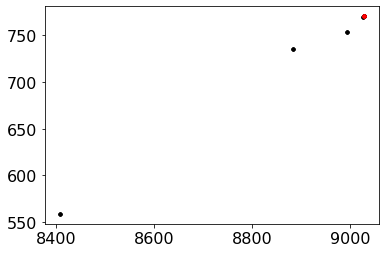

In [31]:
plt.scatter(RC['A'],RC['Ea'],s = 10, c = 'black')
plt.scatter(res.x[0],res.x[1],s = 15, c = 'red')
#plt.xlim([9027,9029])
#plt.ylim([700,800])
plt.show()

- Bom, como a região de confiança não saiu boa, vamos tentar outra abordagem...

Vamos gerar a região de confiança como uma etapa separada da estimação de parâmetros.

In [32]:
def RCfun(par):
    global RC
    dftemp = df.copy()
    dftemp['km'] = modelo(par[0],par[1],dftemp['T']) # km = k modelo
    dftemp['error'] = (dftemp['k'] - dftemp['km'])**2
    SSE = dftemp['error'].sum() # residual sum of squares
    RC = RC.append({'A':par[0],'Ea':par[1],'Fobj':SSE}, ignore_index=True)

In [36]:
nn = 50 # 200
k1 = np.linspace(10,res.x[0]*0.9+res.x[0],nn)
k2 = np.linspace(50,res.x[1]*0.9+res.x[1],nn)

In [37]:
global RC
RC = pd.DataFrame()
for i in range(nn):
    for j in range(nn):
        RCfun([k1[i],k2[j]])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [38]:
fotm = SSE
p = len(x0) # number of parameters
n = N # number of data points
α = 0.95 # alpha, confidence interval
F_fisher = stats.f.isf(1-α,p,(n-p)) 
#F_fisher = stats.f.ppf(α, p, (n-p)) # mesmo resultado que a conta de cima
print(F_fisher,stats.f.ppf(α, p, (n-p)))

3.8852938346523933 3.8852938346523933


In [39]:
rhs = p/(n-p)*F_fisher*fotm + fotm # right hand side of the last equation
rhs

236600.28325778077

- total de conjunto de parâmetros testados pelo otimizador: *nparams*

In [40]:
nparams = RC.index[-1]+1
nparams

2500

In [41]:
RC.describe()

,A,Ea,Fobj
count,2500.000000,2500.000000,2.500000e+03
mean,8582.073177,757.059110,2.399475e+08
std,5050.090568,416.551803,2.403706e+08
min,10.000000,50.000000,1.453430e+05
25%,4208.566454,396.314666,4.063195e+07
50%,8582.073177,757.059110,1.627186e+08
75%,12955.579901,1117.803553,3.825493e+08
max,17154.146355,1464.118219,1.356059e+09


In [42]:
for i in range(nparams):
    if RC['Fobj'][i] > rhs:
        RC = RC.drop(i) # deletar essa linha do DataFrame
RC = RC.reset_index(drop=True)

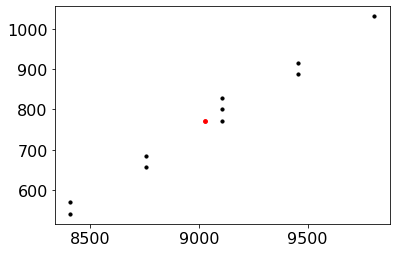

In [43]:
plt.scatter(RC['A'],RC['Ea'],s = 10, c = 'black')
plt.scatter(res.x[0],res.x[1],s = 15, c = 'red')
#plt.xlim([9027,9029])
#plt.ylim([700,800])
plt.show()

- analisando o gráfico acima, podemos ver que dá para aumentar o conjunto de dados gerados...

In [52]:
nn = 500
k1 = np.linspace(10,res.x[0]*0.9+res.x[0],nn)
k2 = np.linspace(50,res.x[1]*0.9+res.x[1],nn)

In [53]:
global RC
RC = pd.DataFrame()
for i in range(nn):
    for j in range(nn):
        RCfun([k1[i],k2[j]])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [54]:
fotm = SSE
p = len(x0) # number of parameters
n = N # number of data points
α = 0.95 # alpha, confidence interval
F_fisher = stats.f.isf(1-α,p,(n-p)) 
#F_fisher = stats.f.ppf(α, p, (n-p)) # mesmo resultado que a conta de cima
print(F_fisher,stats.f.ppf(α, p, (n-p)))

3.8852938346523933 3.8852938346523933


In [55]:
rhs = p/(n-p)*F_fisher*fotm + fotm # right hand side of the last equation
rhs

236600.28325778077

- total de conjunto de parâmetros testados pelo otimizador: *nparams*

In [56]:
nparams = RC.index[-1]+1
nparams

250000

In [57]:
RC.describe()

,A,Ea,Fobj
count,250000.000000,250000.000000,2.500000e+05
mean,8582.073177,757.059110,2.312313e+08
std,4959.006770,409.038845,2.311818e+08
min,10.000000,50.000000,1.436868e+05
25%,4296.036589,403.529555,3.934195e+07
50%,8582.073177,757.059110,1.562935e+08
75%,12868.109766,1110.588664,3.685480e+08
max,17154.146355,1464.118219,1.356059e+09


In [ ]:
for i in range(nparams):
    if RC['Fobj'][i] > rhs:
        RC = RC.drop(i) # deletar essa linha do DataFrame
RC = RC.reset_index(drop=True)

In [ ]:
plt.scatter(RC['A'],RC['Ea'],s = 30, c = 'black',alpha = 0.15)
plt.scatter(res.x[0],res.x[1],s = 15, c = 'red')
#plt.xlim([9027,9029])
#plt.ylim([700,800])
plt.show()

# Atividade

- Refazer o notebook considerando grau de confiança igual a 99 %.